# Consensus clustering

Consensus clustering is a powerful technique for overcoming the instability of single community detection runs. While a single algorithm might give you one partition of a network, running it multiple times can often produce different results, leaving you unsure of which outcome is the most reliable.

This notebook introduces the concept of **consensus clustering**, a method that combines the results of multiple community detection runs to produce a more stable and robust community structure. It aims to identify communities that are consistently found across different runs and are therefore more likely to be true representations of the underlying data structure.

We will learn how to:

* Run a community detection algorithm multiple times on the same network.

* Construct a **co-occurrence matrix** to track how often nodes are clustered together.

* Use this matrix to find a final, more stable consensus partition.

---

In [1]:
import numpy as np
import random
import pandas as pd
import seaborn as sns
import igraph as ig
import matplotlib.pyplot as plt
ig.config["plotting.backend"] = "matplotlib"

In [2]:
%run -i functions.ipynb

In [3]:
def run_clustering(graph, num_runs, community_detection_method, params=None):
    cooccurrence_matrix = np.zeros((graph.vcount(), graph.vcount()))
    community_detection = build_community_detection_method(graph, community_detection_method, params)
        
    # Run the community detection algorithm for multiple seeds and accumulate the co-occurrence matrix
    for seed in range(num_runs):
        random.seed(seed)
        np.random.seed(seed)
        partition = community_detection(seed)
        # Update cooccurrence matrix
        for community in partition:
            for i in community:
                for j in community:
                    cooccurrence_matrix[i, j] += 1
                    
    cooccurrence_matrix /= num_runs

    return cooccurrence_matrix


def build_cooccurrence_df(cooccurrence_matrix):
    cooccurrence_df = pd.DataFrame(cooccurrence_matrix)
    cooccurrence_df = cooccurrence_df.loc[cooccurrence_df.sum(axis=1).sort_values(ascending=False).index, 
        cooccurrence_df.sum(axis=0).sort_values(ascending=False).index]
    return cooccurrence_df

def build_graph(cooccurrence_matrix, graph):
    num_nodes = cooccurrence_matrix.shape[0]
    if 'name' in graph.vs.attributes():
        num_vs = graph.vcount()
        node_names = [graph.vs[i]['name'] for i in range(num_vs)]
    else:
        node_names = [f'Item_{i}' for i in range(num_nodes)]

    edges = []
    weights = []
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes): 
            edges.append((i, j))
            weights.append(cooccurrence_matrix[i, j])
    
    graph = ig.Graph(n=num_nodes, edges=edges, directed=False)
    graph.es['weight'] = weights 
    graph.vs['name'] = node_names

    return graph

def run_consensus_clustering(graph, num_runs, community_detection_method, params=None, plot=True, title="Co-occurrence Matrix Heatmap (Louvain Method)"):
    cooccurrence_matrix = run_clustering(graph, num_runs, community_detection_method, params)

    g = build_graph(cooccurrence_matrix, graph)
    
    if plot:
        cooccurrence_df = build_cooccurrence_df(cooccurrence_matrix)
        
        # Get the sorted indices from the DataFrame
        sorted_indices = cooccurrence_df.index.tolist()
        
        # Use these indices to reorder the node names
        sorted_node_names = [g.vs[i]['name'] for i in sorted_indices]
        
        # Now pass the correctly sorted names to the plotting function
        plot_heatmap_with_names(cooccurrence_df, title, sorted_node_names)
        
    le_clusters = g.community_leading_eigenvector(weights='weight')
    print(f"\nLeading Eigenvector found {len(le_clusters)} communities.")
    for i, cluster in enumerate(le_clusters):
        print(f"  Community {i+1}: {[g.vs[node]['name'] for node in cluster]}")
    modularity_le = g.modularity(le_clusters, weights='weight')
    print(f"  Modularity (Leading Eigenvector): {modularity_le:.4f}")

def plot_heatmap_with_names(cooccurrence_df, title, node_names):
    plt.figure(figsize=(20, 20))
    sns.heatmap(
        cooccurrence_df,
        cmap="viridis",
        cbar=True,
        xticklabels=node_names,
        yticklabels=node_names
    )
    plt.title(title)
    plt.show()

In [4]:
karate_club = ig.Graph.Famous("Zachary")

In [5]:
num_runs = 500

## Karate club

First, we'll run consensus clustering on the Karate club network with the `multilevel` (Leiden) algorithm for **500 runs**. Then, to obtain the final community structure, we'll apply the non-stochastic `leading_eigenvector` algorithm.

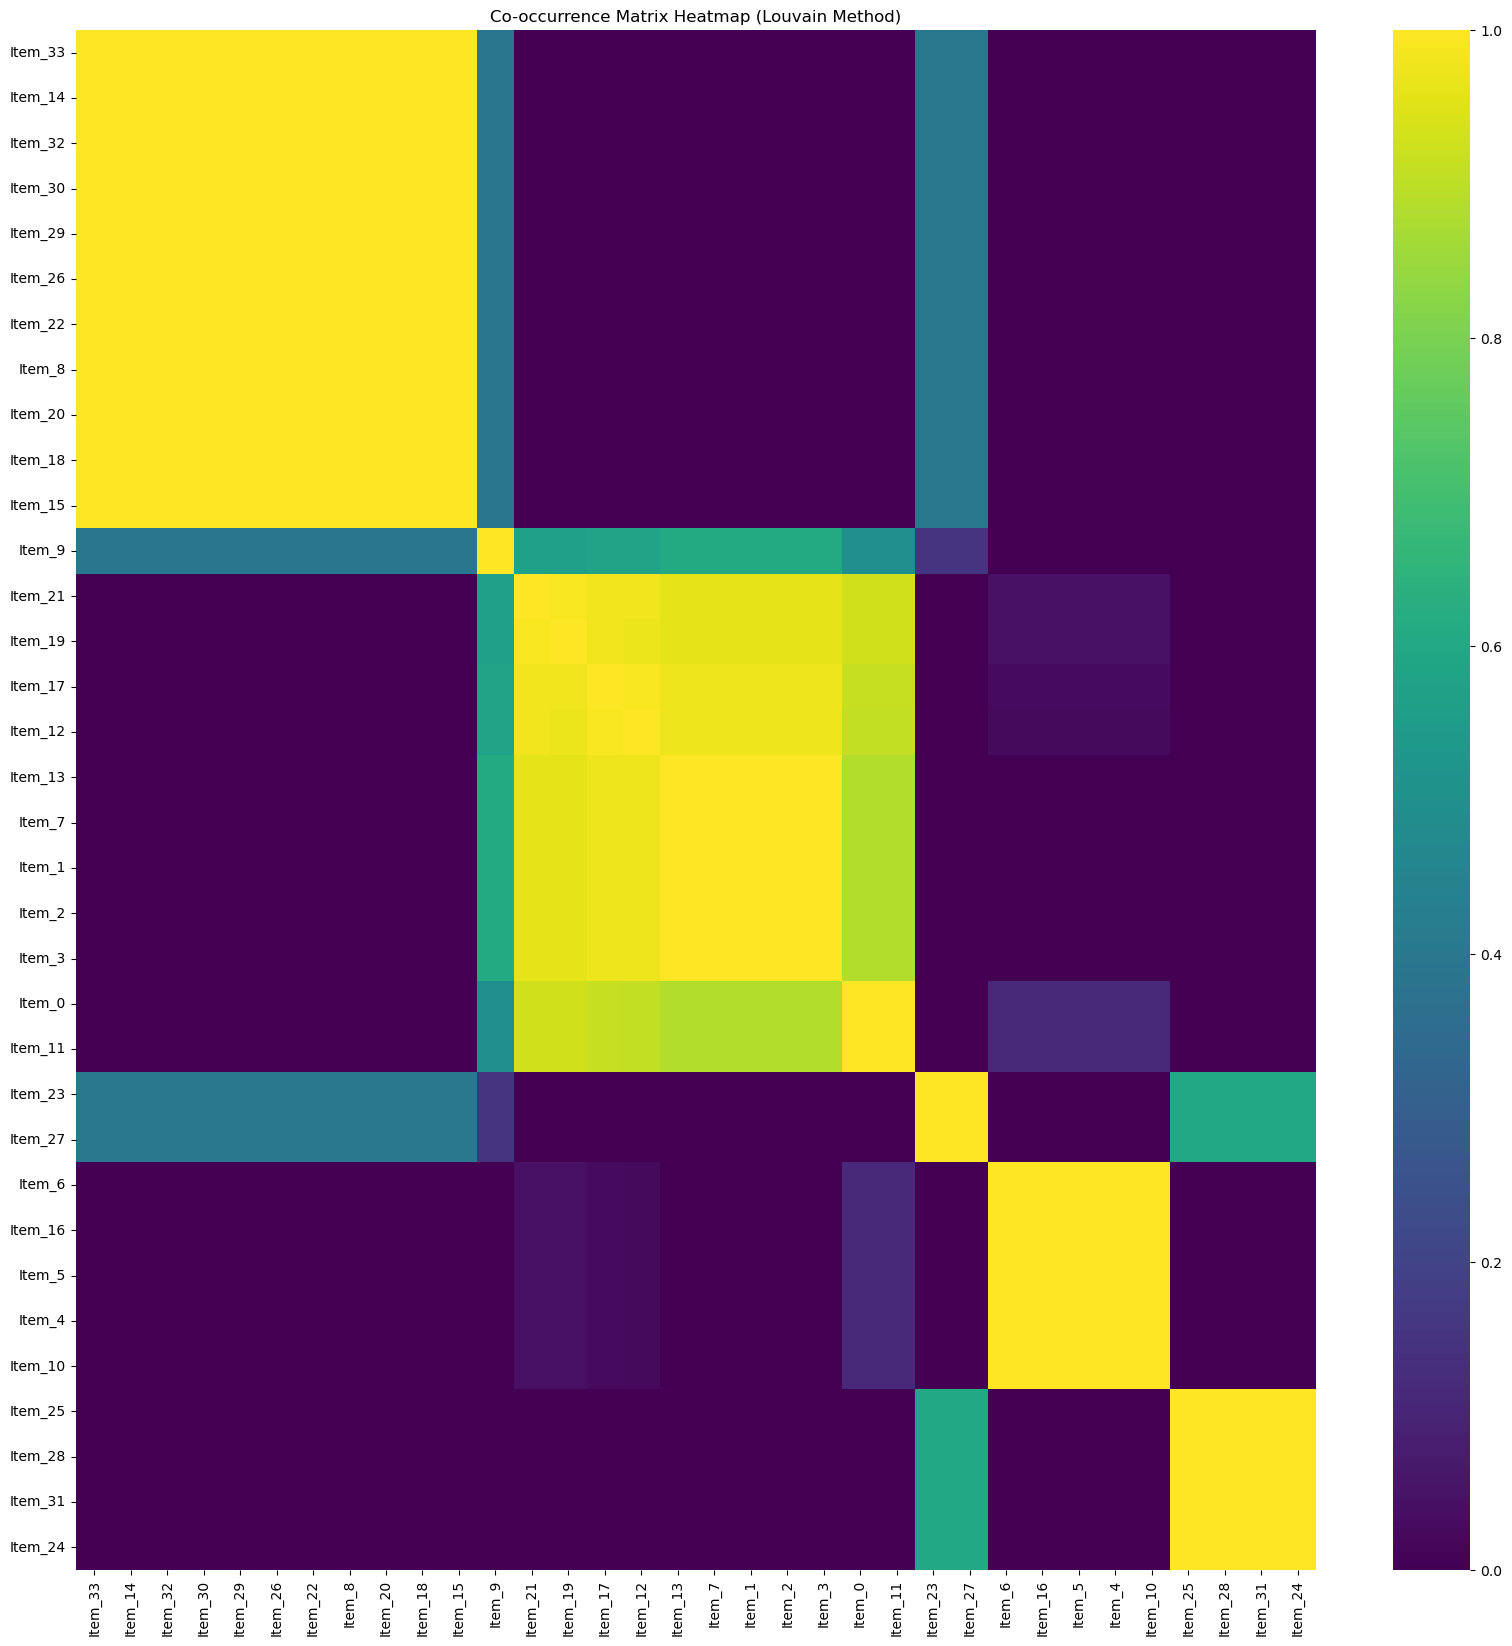


Leading Eigenvector found 4 communities.
  Community 1: ['Item_0', 'Item_1', 'Item_2', 'Item_3', 'Item_7', 'Item_9', 'Item_11', 'Item_12', 'Item_13', 'Item_17', 'Item_19', 'Item_21']
  Community 2: ['Item_8', 'Item_14', 'Item_15', 'Item_18', 'Item_20', 'Item_22', 'Item_26', 'Item_29', 'Item_30', 'Item_32', 'Item_33']
  Community 3: ['Item_4', 'Item_5', 'Item_6', 'Item_10', 'Item_16']
  Community 4: ['Item_23', 'Item_24', 'Item_25', 'Item_27', 'Item_28', 'Item_31']
  Modularity (Leading Eigenvector): 0.5452


In [6]:
run_consensus_clustering(karate_club, num_runs, community_detection_method="multilevel", plot=True, title="Co-occurrence Matrix Heatmap (Louvain Method)")

Secondly, we apply the `leiden` algorithm, using **modularity** as the `objective_function` and a `resolution` of $1$.

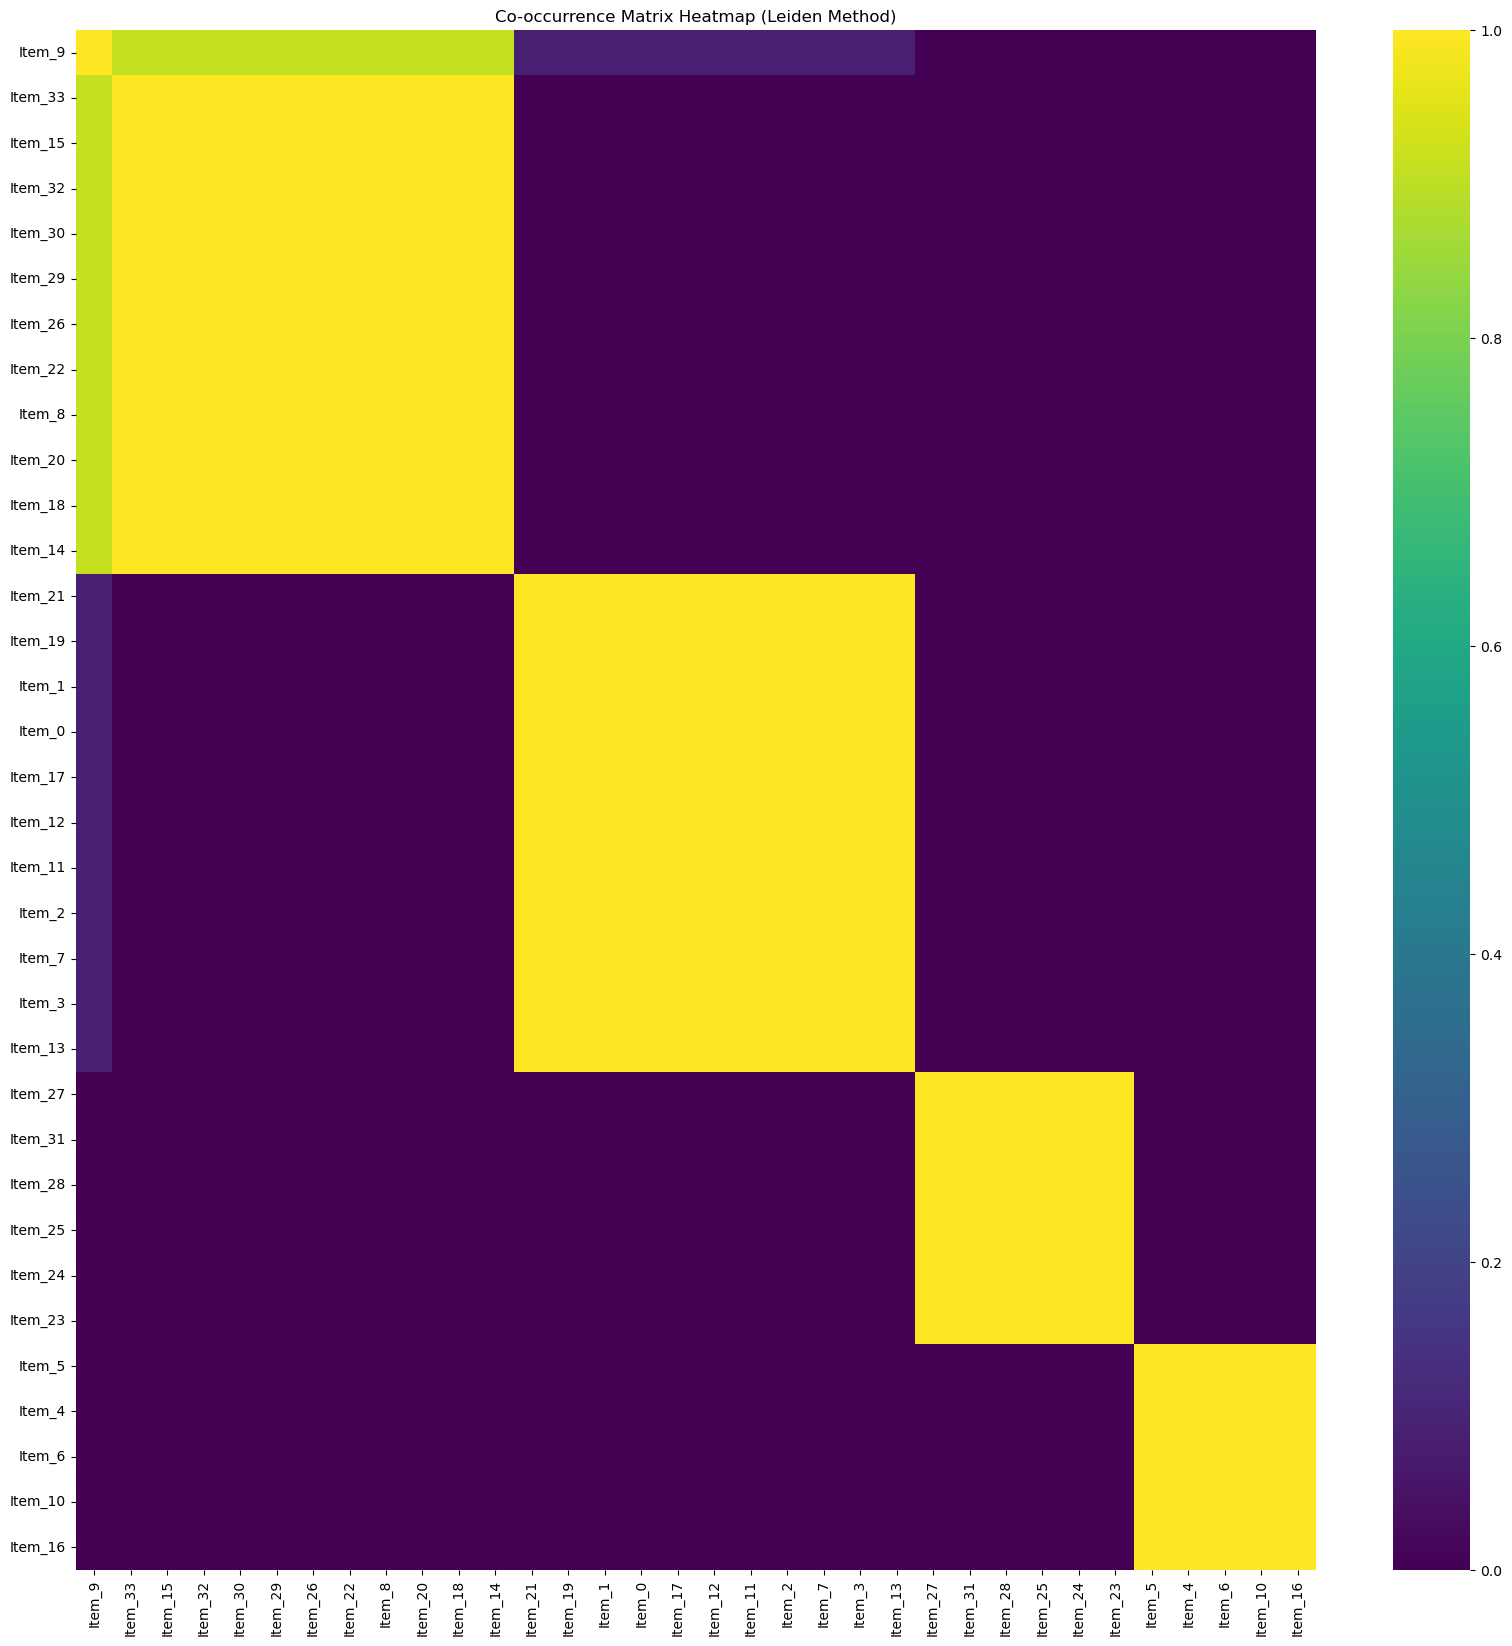


Leading Eigenvector found 4 communities.
  Community 1: ['Item_0', 'Item_1', 'Item_2', 'Item_3', 'Item_7', 'Item_11', 'Item_12', 'Item_13', 'Item_17', 'Item_19', 'Item_21']
  Community 2: ['Item_8', 'Item_9', 'Item_14', 'Item_15', 'Item_18', 'Item_20', 'Item_22', 'Item_26', 'Item_29', 'Item_30', 'Item_32', 'Item_33']
  Community 3: ['Item_4', 'Item_5', 'Item_6', 'Item_10', 'Item_16']
  Community 4: ['Item_23', 'Item_24', 'Item_25', 'Item_27', 'Item_28', 'Item_31']
  Modularity (Leading Eigenvector): 0.6325


In [7]:
params = {
    "objective_function": "modularity",
    "resolution": np.ones(num_runs)
}
run_consensus_clustering(karate_club, num_runs, community_detection_method="leiden", params=params, plot=True, title="Co-occurrence Matrix Heatmap (Leiden Method)")

## Game of Thrones

We can apply the same concept to the **directed** Game of Thrones network, passing the **weight** attribute as the `weights` parameter.

In [8]:
got_network = ig.Graph.Read_GraphML("../networks/game_of_thrones/GoT.graphml")

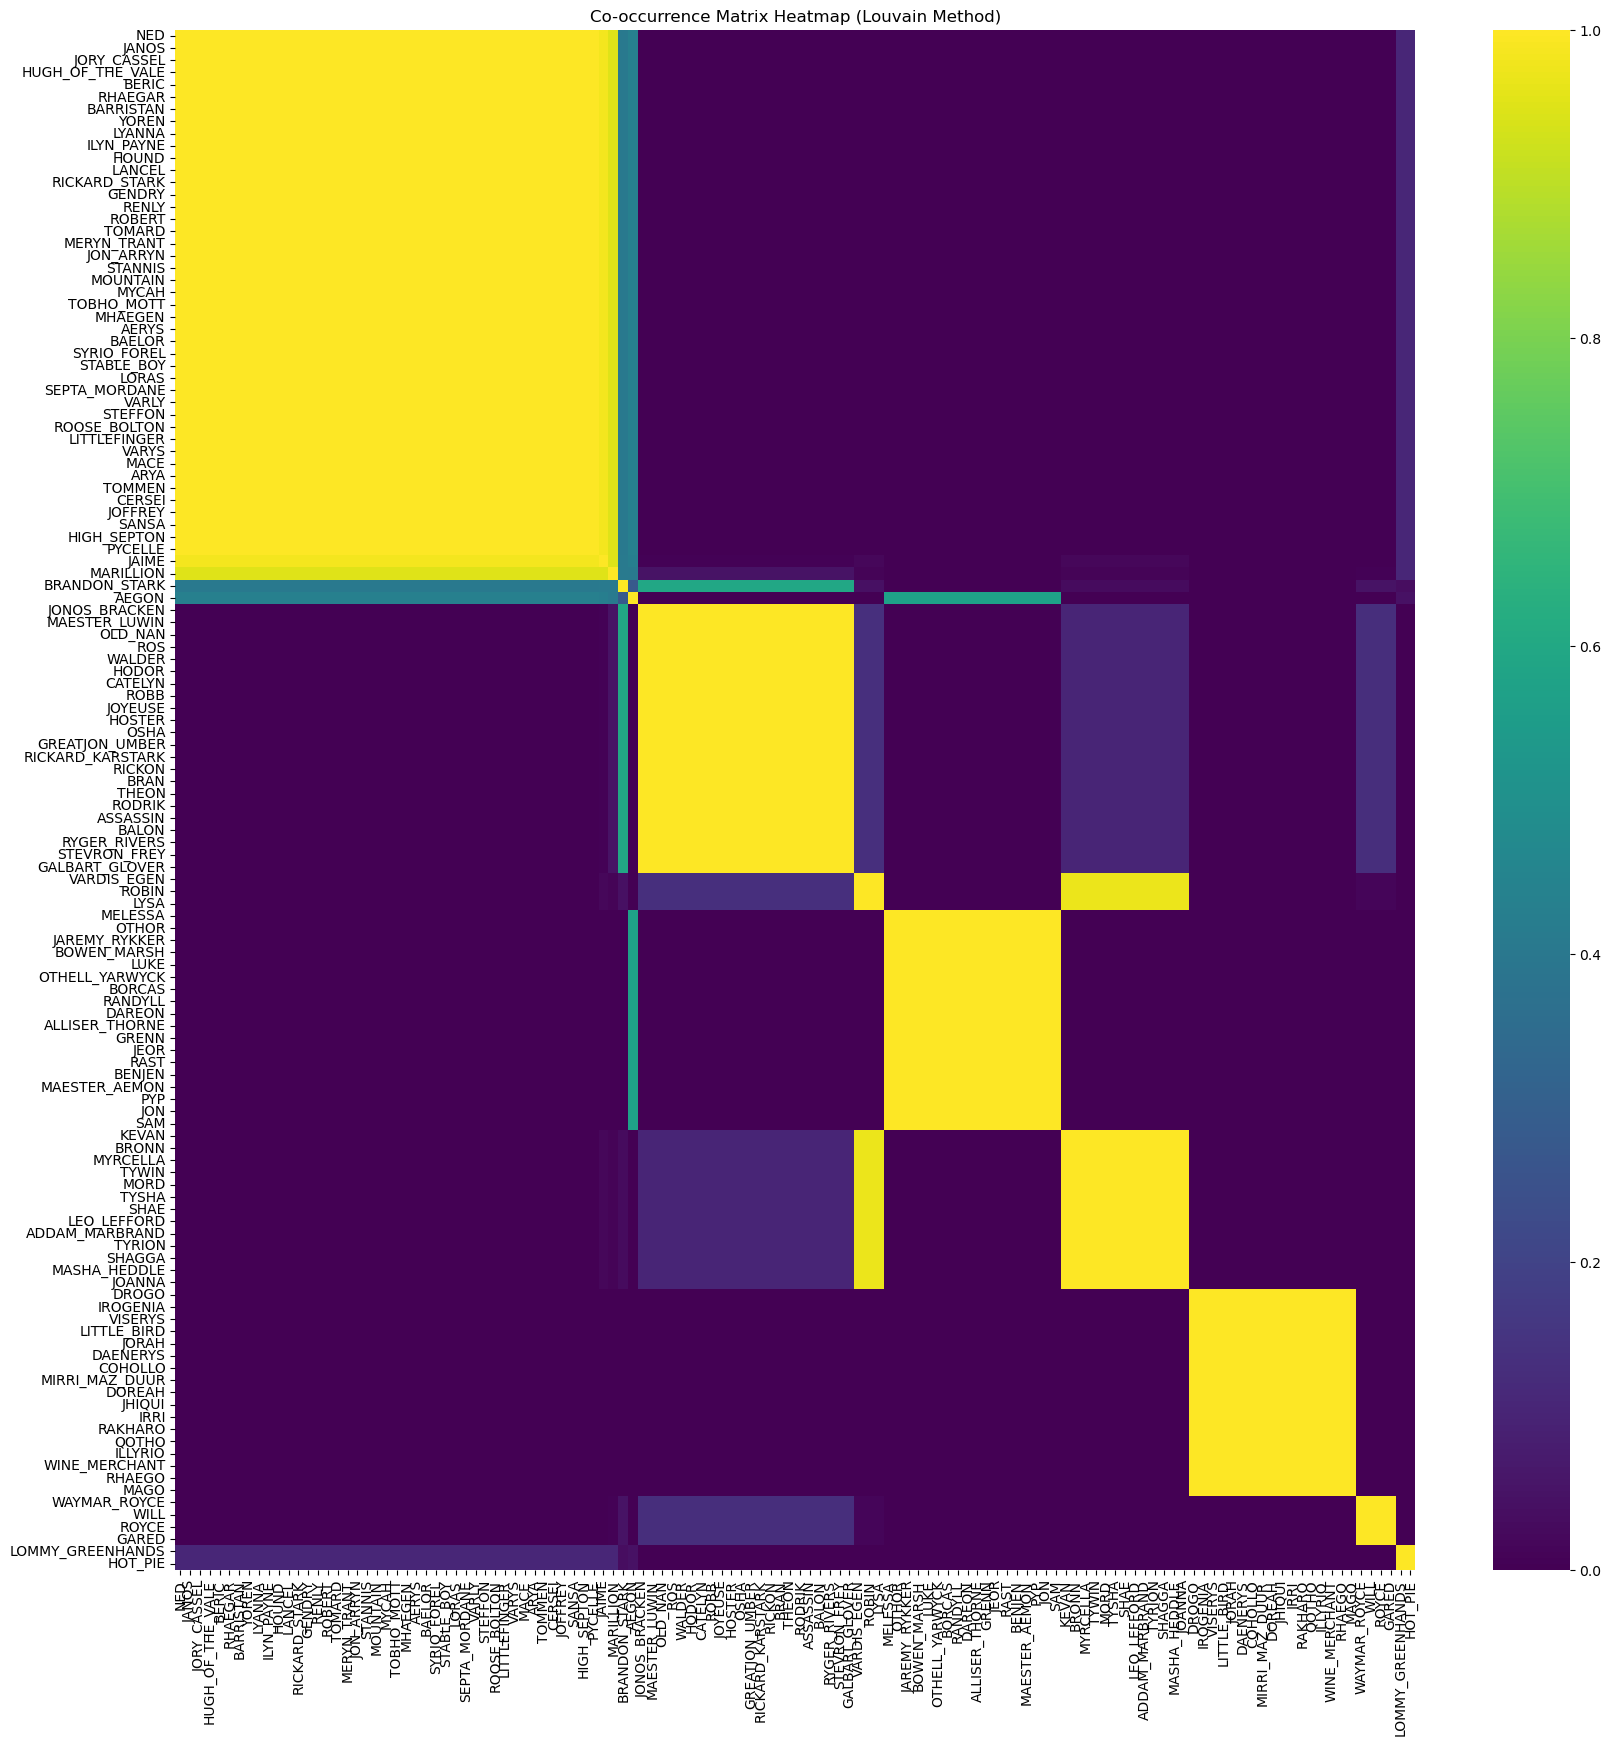


Leading Eigenvector found 5 communities.
  Community 1: ['NED', 'ROBERT', 'LITTLEFINGER', 'VARYS', 'ARYA', 'CERSEI', 'JOFFREY', 'SANSA', 'PYCELLE', 'SEPTA_MORDANE', 'JAIME', 'LORAS', 'RENLY', 'SYRIO_FOREL', 'JORY_CASSEL', 'BARRISTAN', 'YOREN', 'HOUND', 'LANCEL', 'MARILLION', 'JANOS', 'GENDRY', 'HOT_PIE', 'LOMMY_GREENHANDS', 'MERYN_TRANT', 'JON_ARRYN', 'STANNIS', 'MYCAH', 'TOBHO_MOTT', 'MHAEGEN', 'AERYS', 'BAELOR', 'STABLE_BOY', 'HUGH_OF_THE_VALE', 'MOUNTAIN', 'TOMARD', 'RICKARD_STARK', 'ILYN_PAYNE', 'LYANNA', 'RHAEGAR', 'BERIC', 'AEGON', 'HIGH_SEPTON', 'TOMMEN', 'MACE', 'ROOSE_BOLTON', 'STEFFON', 'VARLY']
  Community 2: ['DAENERYS', 'JORAH', 'DROGO', 'VISERYS', 'MIRRI_MAZ_DUUR', 'DOREAH', 'IRRI', 'RAKHARO', 'QOTHO', 'ILLYRIO', 'WINE_MERCHANT', 'RHAEGO', 'MAGO', 'COHOLLO', 'JHIQUI', 'IROGENIA', 'LITTLE_BIRD']
  Community 3: ['CATELYN', 'ROBB', 'THEON', 'BRAN', 'MAESTER_LUWIN', 'ROS', 'WALDER', 'GREATJON_UMBER', 'OSHA', 'RODRIK', 'RICKON', 'HODOR', 'OLD_NAN', 'GARED', 'ROYCE', 'JONOS_BR

In [9]:
params = {
    "weights": "weight"
}
run_consensus_clustering(got_network, num_runs, community_detection_method="multilevel", plot=True, params=params)

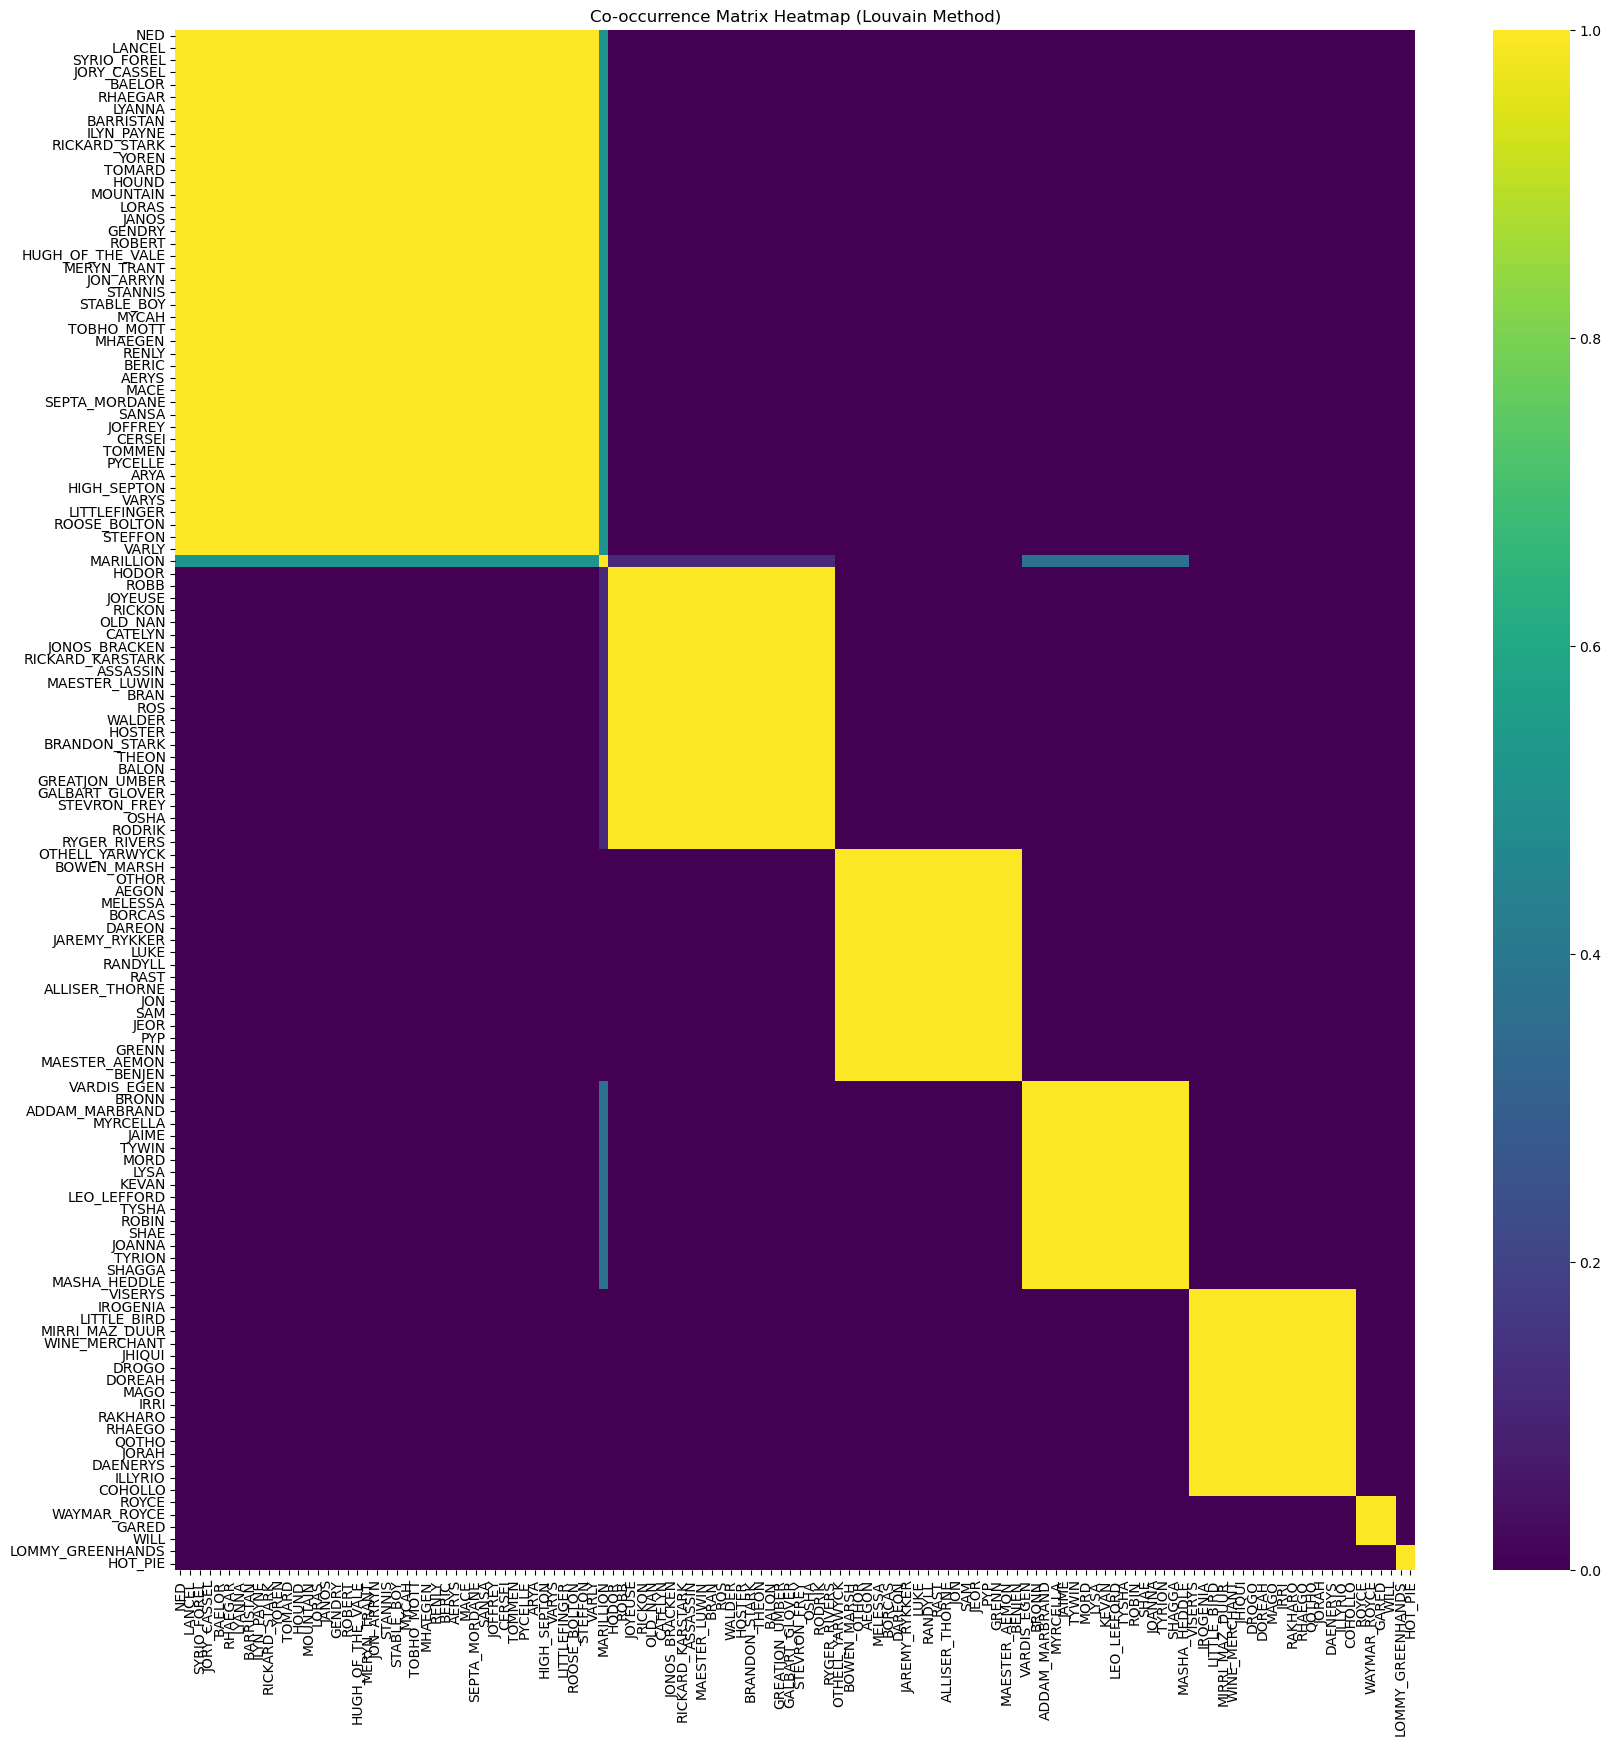


Leading Eigenvector found 7 communities.
  Community 1: ['NED', 'ROBERT', 'LITTLEFINGER', 'VARYS', 'ARYA', 'CERSEI', 'JOFFREY', 'SANSA', 'PYCELLE', 'SEPTA_MORDANE', 'LORAS', 'RENLY', 'SYRIO_FOREL', 'JORY_CASSEL', 'BARRISTAN', 'YOREN', 'HOUND', 'LANCEL', 'MARILLION', 'JANOS', 'GENDRY', 'MERYN_TRANT', 'JON_ARRYN', 'STANNIS', 'MYCAH', 'TOBHO_MOTT', 'MHAEGEN', 'AERYS', 'BAELOR', 'STABLE_BOY', 'HUGH_OF_THE_VALE', 'MOUNTAIN', 'TOMARD', 'RICKARD_STARK', 'ILYN_PAYNE', 'LYANNA', 'RHAEGAR', 'BERIC', 'HIGH_SEPTON', 'TOMMEN', 'MACE', 'ROOSE_BOLTON', 'STEFFON', 'VARLY']
  Community 2: ['DAENERYS', 'JORAH', 'DROGO', 'VISERYS', 'MIRRI_MAZ_DUUR', 'DOREAH', 'IRRI', 'RAKHARO', 'QOTHO', 'ILLYRIO', 'WINE_MERCHANT', 'RHAEGO', 'MAGO', 'COHOLLO', 'JHIQUI', 'IROGENIA', 'LITTLE_BIRD']
  Community 3: ['CATELYN', 'ROBB', 'THEON', 'BRAN', 'MAESTER_LUWIN', 'ROS', 'WALDER', 'GREATJON_UMBER', 'OSHA', 'RODRIK', 'RICKON', 'HODOR', 'OLD_NAN', 'JONOS_BRACKEN', 'RYGER_RIVERS', 'STEVRON_FREY', 'ASSASSIN', 'BALON', 'BRAND

In [10]:
params = {
    "objective_function": "modularity",
    "resolution": np.ones(num_runs),
    "weights": "weight"
}
run_consensus_clustering(got_network, num_runs, community_detection_method="leiden", params=params, plot=True, title="Co-occurrence Matrix Heatmap (Louvain Method)")